In [28]:
# Import necessary libraries
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
from src.integrated_hessians import integrated_hessians
import spacy
from nltk.corpus import stopwords
from src.model_utils import load_model_and_tokenizer, visualize_attributions, visualize_hessians, find_most_important_tokens_from_hessians, visualize_filtered_hessians
from src.integrated_gradients import integrated_gradients
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [29]:
model_name = 'lyrisha/distilbert-base-finetuned-sentiment'
tokenizer, model = load_model_and_tokenizer(model_name)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [30]:
# Load example text
text = "this movie was not bad at all."

#shuffle text to check model's sanity if needed
def shuffle_tokens_and_check(text):
    print("Original:", text)
    shuffled=text.split()
    random.shuffle(shuffled)
    text = ' '.join(shuffled)
    print("Shuffled:", text)
    return text


#text = shuffle_tokens_and_check(text)

# Tokenize input and baseline (all zeros => [PAD] token)
tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=64, truncation=True).to(device)
input_ids = tokens['input_ids']
pad_id = tokenizer.pad_token_id
baseline_ids = torch.full_like(input_ids, pad_id).to(device)

# Decoding for plots
decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

valid_length = (input_ids[0] != pad_id).sum().item()
decoded_tokens = decoded_tokens[:valid_length]

In [31]:
with torch.no_grad():
    logits = model(input_ids).logits
    target_class = torch.argmax(logits, dim=1).item()
    probs = torch.softmax(logits, dim=1)
    confidence = probs[0, target_class].item()


print(f'Predicted class {"negative" if target_class == 0 else "positive"} with confidence: {confidence:.2f}')


Predicted class positive with confidence: 0.88


In [32]:
# Run Integrated Gradients to compute token attributions
hessians = integrated_gradients(model, input_ids, baseline_ids, steps=50, target_class=target_class)

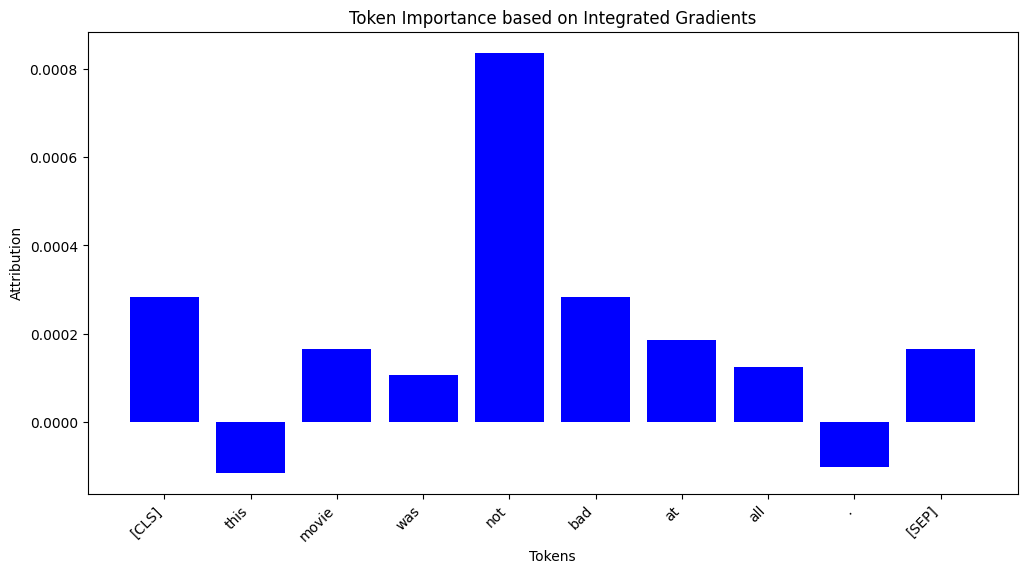

In [33]:
visualize_attributions(hessians, decoded_tokens, valid_length)

In [34]:
hessians = integrated_hessians(model, input_ids, baseline_ids, steps=50, target_class=target_class)

Processing alphas: 100%|██████████| 50/50 [02:31<00:00,  3.03s/step]


['this', 'movie', 'was', 'not', 'bad', 'at', 'all', '.']


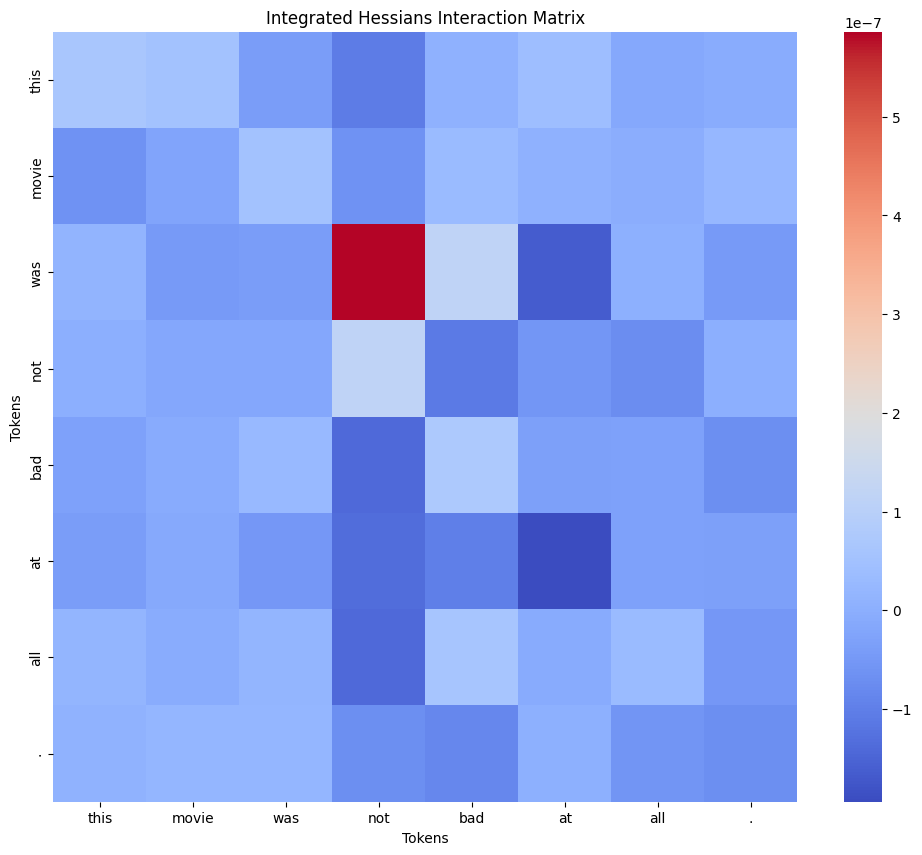

In [35]:
visualize_hessians(hessians[1:, 1:], decoded_tokens[1:-1])

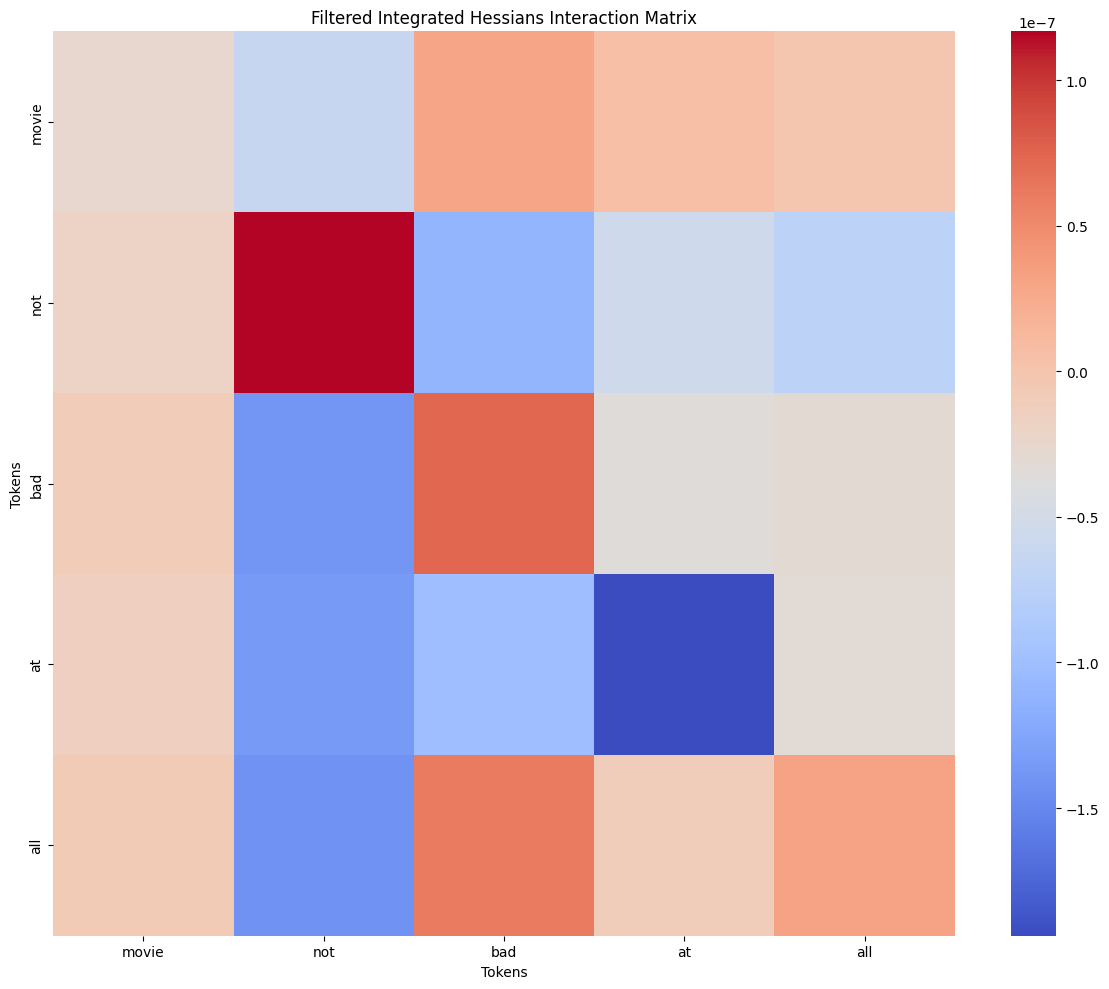

In [36]:
visualize_filtered_hessians(hessians[1:, 1:], decoded_tokens[1:-1], valid_length)


In [37]:

find_most_important_tokens_from_hessians(hessians[1:, 1:], decoded_tokens[1:-1], valid_length)


Most important tokens (by interaction): not bad


('not', 'bad')